In [5]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 
import gzip

Cargo los datos

In [6]:


# Abre el archivo comprimido y carga los datos JSON
with gzip.open("steam_games.json.gz", 'rt', encoding='utf-8') as archivo_comprimido:
    # Carga los datos JSON en un DataFrame
    games = pd.read_json(archivo_comprimido, lines=True)
reviews = pd.read_parquet('user_reviews.parquet')
item = pd.read_parquet('australian_users_items.parquet')

## EDA  steam_games:

Vemos un primer viztazo a los datos, las primeras y ultimas filas:

In [7]:
games.head()


,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
1,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
2,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
3,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
4,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


In [9]:
#Ultimas 5 filas:
games.tail()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns"
120444,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,1.0,681550.0,None


Notamos que no todas las filas son nulas revisamos cuantas son

In [19]:
#Cantidad de filas nulas
filas_con_nulos = games[games.isnull().all(axis=1)]
print(f" La cantidad de filas nulas son: {len(filas_con_nulos)}")

 La cantidad de filas nulas son: 88310


Con respecto a las filas que no son nulas notamos que las columnas 'tags' y 'genres' tienen valores parecidos, ademas ambas columnas estan anidadas, por lo que se debería desanidar:

In [11]:
games[["tags","genres"]].tail()

,tags,genres
120440,"[Strategy, Indie, Casual, Simulation]","[Casual, Indie, Simulation, Strategy]"
120441,"[Strategy, Indie, Casual]","[Casual, Indie, Strategy]"
120442,"[Indie, Simulation, Racing]","[Indie, Racing, Simulation]"
120443,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Casual, Indie]"
120444,"[Early Access, Adventure, Indie, Action, Simul...",None


De la columna "release_date" viene la fecha completa y para el proyecto solo necesito el año. El cual se debera sacar solo el año:

In [12]:
games.release_date.tail() 

120440    2018-01-04
120441    2018-01-04
120442    2018-01-04
120443    2017-09-02
120444          None
Name: release_date, dtype: object

También notamos que de la columna 'price' hay precios que deberian ser 0 y estan en palabras como Free to play, Free, Free to use, entre otros mas por ende este un str y deberiamos convertirlos en float una vez corregidos:

In [13]:
games.price.value_counts().tail()

price
74.76          1
32.99          1
14.95          1
26.99          1
Free to Use    1
Name: count, dtype: int64

Arreglamos la columna 'price' para poder guardar el dataset:

Primero revisamo si free to use es el unico valor no numerico

In [14]:
# Convertir la columna 'price' a numérico, los valores no convertibles serán NaN
games['price_numeric'] = pd.to_numeric(games['price'], errors='coerce')

# Filtrar los valores que no son numéricos
valores_no_numericos = games[games['price_numeric'].isna()]['price']

# Obtener el recuento de valores únicos no numéricos
conteo_valores_no_numericos = valores_no_numericos.value_counts()

# Mostrar el recuento de valores únicos no numéricos
print("Recuento de valores únicos no numéricos de la columna 'price':")
print(conteo_valores_no_numericos)

# Obtener el número de valores únicos no numéricos
num_valores_no_numericos_unicos = valores_no_numericos.nunique()

# Imprimir el número de valores únicos no numéricos
print(f"Número de valores únicos no numéricos en la columna 'price': {num_valores_no_numericos_unicos}")

games = games.drop(columns=['price_numeric'])

Recuento de valores únicos no numéricos de la columna 'price':
price
Free                             905
Free to Play                     520
Free To Play                     462
Free Mod                           4
Free Demo                          3
Play Now                           2
Third-party                        2
Play for Free!                     2
Play WARMACHINE: Tactics Demo      1
Install Theme                      1
Install Now                        1
Free HITMAN™ Holiday Pack          1
Play the Demo                      1
Starting at $499.00                1
Starting at $449.00                1
Free to Try                        1
Free Movie                         1
Free to Use                        1
Name: count, dtype: int64
Número de valores únicos no numéricos en la columna 'price': 18


Vemos que hay 18 valores no numericos procedemos a remplazarlor por 0.00 debido a que la mayoria es para decir gratis

In [17]:
# Definir un diccionario de mapeo de valores a reemplazar y su valor de reemplazo
mapeo_reemplazo = {'Free': '0', 'Free To Play': '0', 'Free Mod' : '0' ,'Free Demo' : '0' ,'Play for Free!' :'0' ,'Third-party' : '0' ,'Play Now' : '0' ,'Install Now' : '0' ,'Play WARMACHINE: Tactics Demo' : '0' ,'Install Theme' : '0' ,'Free HITMAN™ Holiday Pack' : '0' ,'Play the Demo' : '0' ,'Free to Try' : '0' ,'Free to Use' : '0','Free to Play' : '0','Starting at $449.00' : '0','Starting at $499.00 ' : '0','Free Movie' : '0'}

# Reemplazar los valores en la columna 'price' según el diccionario de mapeo
games['price'] = games['price'].replace(mapeo_reemplazo)
games['price'] = pd.to_numeric(games['price'], errors='coerce')
#esta ultima linia combierte los '0' = 0.00 

Comprobamos


In [20]:
# Convertir la columna 'price' a numérico, los valores no convertibles serán NaN
games['price_numeric'] = pd.to_numeric(games['price'], errors='coerce')

# Filtrar los valores que no son numéricos
valores_no_numericos = games[games['price_numeric'].isna()]['price']

# Obtener el recuento de valores únicos no numéricos
conteo_valores_no_numericos = valores_no_numericos.value_counts()

# Mostrar el recuento de valores únicos no numéricos
print("Recuento de valores únicos no numéricos de la columna 'price':")
print(conteo_valores_no_numericos)

# Obtener el número de valores únicos no numéricos
num_valores_no_numericos_unicos = valores_no_numericos.nunique()

# Imprimir el número de valores únicos no numéricos
print(f"Número de valores únicos no numéricos en la columna 'price': {num_valores_no_numericos_unicos}")

games = games.drop(columns=['price_numeric'])

Recuento de valores únicos no numéricos de la columna 'price':
Series([], Name: count, dtype: int64)
Número de valores únicos no numéricos en la columna 'price': 0


Vemos también el top 10 de las desarrolladoras que mas juegos relizaron de la columna 'developer':

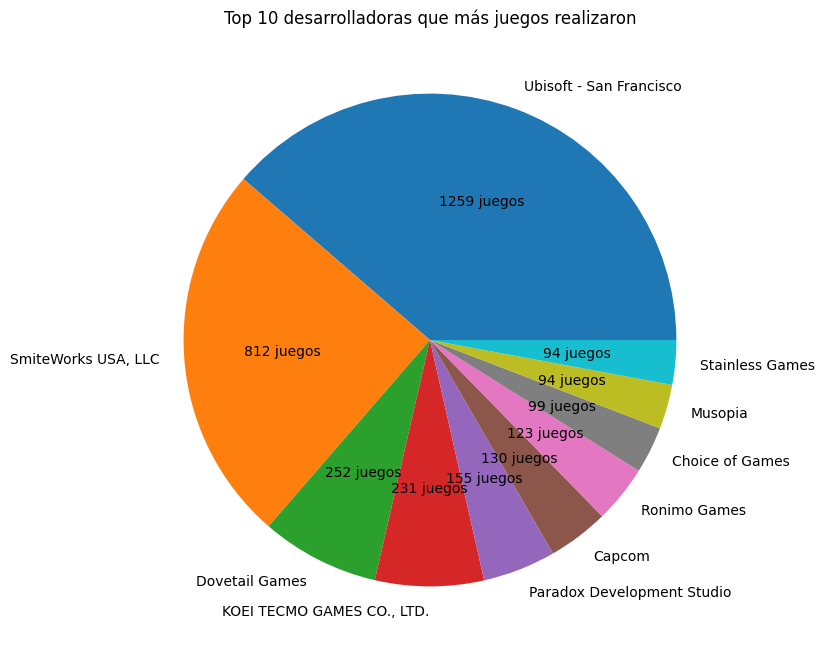

In [21]:
# Calcular la cantidad de datos por desarrollador
cantidad_juegos_por_desarrollador = games['developer'].value_counts()

# Nos quedamos con los 6 que mas juegos realizaron
top_desarrolladores = cantidad_juegos_por_desarrollador.head(10)

# Graficamos
plt.figure(figsize=(8, 8))
plt.pie(top_desarrolladores, labels=top_desarrolladores.index, autopct=lambda p: f'{int(p*sum(top_desarrolladores)/100)} juegos')
plt.title('Top 10 desarrolladoras que más juegos realizaron')
plt.show()

In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30757 non-null  float64
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(3), object(10)
memory usage: 11.9+ MB


vemos la cantidad e filas y columnas

In [23]:
games.shape

(120445, 13)

In [ ]:
games = games.dropna(how='all')
print(games.isnull().sum())